# Image registration for SEQUOIA Localization


As it is a Rededge flight, only the images are co-registered, adjusted using the sun-sensor and saved as 4 channel .tifs
* For the following Dataset: https://zenodo.org/records/4076075
* Using code snippets from:

Output: `uint16` 0-65535 scaled .tif files with green, red, rededge, nir bands


1. Extract metadata from TIFF images using tifffile and exifread.
2. Normalize raw pixel values using the black level.
3. Apply vignetting correction based on the polynomial coefficients from the metadata.
4. Apply distortion correction using OpenCV's undistort() function.
5. Calculate camera signal values using gain and exposure time.
6. Account for irradiance values from the sunlight sensor.
7. Compute reflectance.


In [2]:
import os
import numpy as np
from glob import glob
from multiprocessing import Pool
from itertools import repeat
from PIL import Image
import piexif
import cv2
from tqdm import tqdm
import tifffile
import tifftools
from xml.etree import cElementTree as ElementTree
from tifffile import TiffFile
import cv2
import numpy as np
import tifffile as tiff
from PIL import Image

def clean_xml(xml_string):

    # Trim the XML to start and end at <x:xmpmeta>
    start_index = xml_string.find('<x:xmpmeta')
    end_index = xml_string.rfind('</x:xmpmeta>') + len('</x:xmpmeta>')

    # Extract only the portion of the string between the <x:xmpmeta> tags
    if start_index != -1 and end_index != -1:
        xml_string = xml_string[start_index:end_index]

    
    return xml_string


class XmlListConfig(list):
    def __init__(self, aList):
        for element in aList:
            if element:
                # treat like dict
                if len(element) == 1 or element[0].tag != element[1].tag:
                    self.append(XmlDictConfig(element))
                # treat like list
                elif element[0].tag == element[1].tag:
                    self.append(XmlListConfig(element))
            elif element.text:
                text = element.text.strip()
                if text:
                    self.append(text)


class XmlDictConfig(dict):
    '''
    Example usage:

    >>> tree = ElementTree.parse('your_file.xml')
    >>> root = tree.getroot()
    >>> xmldict = XmlDictConfig(root)

    Or, if you want to use an XML string:

    >>> root = ElementTree.XML(xml_string)
    >>> xmldict = XmlDictConfig(root)

    And then use xmldict for what it is... a dict.
    '''
    def __init__(self, parent_element):
        if parent_element.items():
            self.update(dict(parent_element.items()))
        for element in parent_element:
            if element:
                # treat like dict - we assume that if the first two tags
                # in a series are different, then they are all different.
                if len(element) == 1 or element[0].tag != element[1].tag:
                    aDict = XmlDictConfig(element)
                # treat like list - we assume that if the first two tags
                # in a series are the same, then the rest are the same.
                else:
                    # here, we put the list in dictionary; the key is the
                    # tag name the list elements all share in common, and
                    # the value is the list itself 
                    aDict = {element[0].tag: XmlListConfig(element)}
                # if the tag has attributes, add those to the dict
                if element.items():
                    aDict.update(dict(element.items()))
                self.update({element.tag: aDict})
            # this assumes that if you've got an attribute in a tag,
            # you won't be having any text. This may or may not be a 
            # good idea -- time will tell. It works for the way we are
            # currently doing XML configuration files...
            elif element.items():
                self.update({element.tag: dict(element.items())})
            # finally, if there are no child tags and no attributes, extract
            # the text
            else:
                self.update({element.tag: element.text})


def undistort_image(nir_image, metadata):
    # Parse the metadata
    root = ET.fromstring(metadata["XMP"])
    xmldict = XmlDictConfig(root)
    base = xmldict['{http://www.w3.org/1999/02/22-rdf-syntax-ns#}RDF']['{http://www.w3.org/1999/02/22-rdf-syntax-ns#}Description']


    # get image dimensions
    xDim = nir_image.shape[0]
    yDim = nir_image.shape[1]
    

    #fiseye undistort:

    # Extract fisheye affine matrix from metadata
    affine_matrix = base['{http://pix4d.com/camera/1.0/}FisheyeAffineMatrix'].split(",")
    
    affine_matrix = [float(x) for x in affine_matrix]
    
    # Build the camera matrix for fisheye camera (assumed from the affine matrix)
    K = np.array([[affine_matrix[0], 0, xDim / 2],
                  [0, affine_matrix[3], yDim / 2],
                  [0, 0, 1]], dtype=np.float32)
       # Assuming the format is: [k1, k2, k3, k4]
    D = base['{http://pix4d.com/camera/1.0/}FisheyePolynomial'].split(",")
    D = np.array([float(x) for x in D], dtype=np.float32)

    map1, map2 = cv2.fisheye.initUndistortRectifyMap(K, D, np.eye(3), K, (yDim, xDim), cv2.CV_16SC2)
    
    # Undistort the image
    undistorted_img = cv2.remap(nir_image, map1, map2, interpolation=cv2.INTER_LINEAR)

    
    return undistorted_img
    
    
def irradiance(nir_image, metadata):

    # Parse the metadata
    root = ET.fromstring(metadata["XMP"])
    xmldict = XmlDictConfig(root)
    base = xmldict['{http://www.w3.org/1999/02/22-rdf-syntax-ns#}RDF']['{http://www.w3.org/1999/02/22-rdf-syntax-ns#}Description']

    band_id = 1 # calibrated all from NIR 
    #  get radiometric calibration factors

    # get image dimensions
    xDim = nir_image.shape[0]
    yDim = nir_image.shape[1]
    
    # get dark current pixel values
    # get number of stored values
    # Extract necessary metadata values

    # 1) Subtract black level
    black_level = metadata["BlackLevel"]
    black_level = np.array([float(x) for x in black_level])
    dark_level = black_level.mean()

    dn_corrected = nir_image.astype(np.float32) - dark_level
    dn_corrected[dn_corrected < 0] = 0  # clip negative
    dn_corrected = dn_corrected/65535

    #time
    calibration = base['{http://pix4d.com/camera/1.0/}CalibrationMeasurement']
    calibration = calibration.split(",")
    calibration = [float(x) for x in calibration]
    exposure_time = calibration[1]
    # 2) DN rate (divide by exposure time)
    dn_rate = dn_corrected / exposure_time

    # 3) Multiply by band gain (if not 1)
    band_gain = float(base['{http://pix4d.com/camera/1.0/}BandGain'])
    band_gain = float(metadata["ExifTag"]['ISOSpeedRatings'])
    dn_rate *= band_gain

    # 4) Approximate conversion to irradiance
    irr_unit_scale = base[ '{http://pix4d.com/camera/1.0/}IrradianceUnitScale']
    irr_unit_scale = float(irr_unit_scale)

    pixel_irr = dn_rate * irr_unit_scale
    
    irr_calib_measurement =  base['{http://pix4d.com/camera/1.0/}IrradianceCalibrationMeasurement'].split(",")
    irr_calib_measurement = [float(x) for x in irr_calib_measurement]
    irr = {}
    for i in range(0, len(irr_calib_measurement), 4):
        band = irr_calib_measurement[i]
        sunshine = irr_calib_measurement[i+1]
        c = irr_calib_measurement[i+2]
        b = irr_calib_measurement[i+3]
        irr[band] = (sunshine, c,b)
        
    sun_dn_current= irr[band_id][0]
    sun_black_current = irr[band_id][2]
    # 5) Sunshine sensor corrected DN
    sun_dn_corrected = float(sun_dn_current - sun_black_current)
    if sun_dn_corrected < 1:
        sun_dn_corrected = 1  # avoid div by zero or negative

    band_sensitivity = base['{http://pix4d.com/camera/1.0/}IrradianceSensitivitiesGolden'].split(",")
    band_sensitivity = [float(x) for x in band_sensitivity]
    if band_id in (0,1):
        band_sensitivity = band_sensitivity[0]
    else:
        band_sensitivity = band_sensitivity[1]
    

    sun_irr = sun_dn_corrected * band_sensitivity

    reflectance = pixel_irr / sun_irr


    return reflectance

    
# Utility functions
def load_image(filename):
    """Load a single image with the metadata as byte dump."""
    image = np.asarray(Image.open(filename))

    t = TiffFile(filename)
    metadata = t.pages[0].tags
    
    # Convert tifftags to a dictionary
    metadata_dict = {tag.name: tag.value for tag in metadata.values()}
    metadata_dict["XMP"] = metadata_dict["XMP"].decode("utf-8")
    metadata_dict["XMP"] = clean_xml(metadata_dict["XMP"])
    #metadata_dict["ExifTag"]["FileSource"] = metadata_dict["ExifTag"]["FileSource"].decode()
    #metadata_dict["ExifTag"]["SceneType"] = metadata_dict["ExifTag"]["SceneType"].decode()
    metadata_dict["GPSTag"]["GPSVersionID"] = tuple(metadata_dict["GPSTag"]["GPSVersionID"])
    #metadata_dict["XPComment"] = list(metadata_dict["XPComment"])
    #metadata_dict['XPKeywords'] = metadata_dict['XPKeywords'].decode()
    metadata_dict["ExifTag"]["MakerNote"] = 0
    metadata_dict["OpcodeList3"] = 0
    metadata_dict['OriginalRawFileName'] = os.path.basename(filename)
    return image, metadata_dict
    
import xml.etree.ElementTree as ET
def process_xml_dict_3m(xml_string):
    
    root = ET.fromstring(xml_string)
    xmldict = XmlDictConfig(root)
    return xmldict
    
def save_image(filename, image, metadata=None):
    """Save the image as a 4-channel TIFF using tifffile."""
    tifffile.imwrite(filename, image, photometric='rgb',metadata=metadata)

# Create a directory to save homographies
os.makedirs("homographies", exist_ok=True)


def align_images(image1, image2, band_name, base_name, set_title = "set"):
    """Align two images using ORB keypoints and cached affine transformation with quantization."""
    # Create a unique transformation filename

    affine_filename = f"homographies/{band_name}_{set_title}_affine.npy"

    # Quantize images to uint8 if necessary
    image1_8bit = quantize_to_uint8(image1)
    image2_8bit = quantize_to_uint8(image2)

    # Check if the affine transformation is already cached
    if os.path.exists(affine_filename):
        affine_matrix = np.load(affine_filename)
    else:
        # Convert images to grayscale if they are RGB
        if len(image1_8bit.shape) == 3 and image1_8bit.shape[-1] == 3:
            gray1 = cv2.cvtColor(image1_8bit, cv2.COLOR_RGB2GRAY)
        else:
            gray1 = image1_8bit

        if len(image2_8bit.shape) == 3 and image2_8bit.shape[-1] == 3:
            gray2 = cv2.cvtColor(image2_8bit, cv2.COLOR_RGB2GRAY)
        else:
            gray2 = image2_8bit

        # Use ORB to find keypoints and descriptors
        orb = cv2.ORB_create(50000)
        keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
        keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

        # Match descriptors using FLANN-based matcher
        index_params = dict(algorithm=6, table_number=12, key_size=20, multi_probe_level=2)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(descriptors1, descriptors2, k=2)

        # Filter matches using the ratio test
        good_matches = [m for m, n in matches if m.distance < 0.8 * n.distance]

        if len(good_matches) < 3:
            raise ValueError("Not enough good matches to compute affine transformation.")

        # Extract matched points
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        # Compute the affine transformation
        affine_matrix, _ = cv2.estimateAffinePartial2D(dst_pts, src_pts, method=cv2.RANSAC, ransacReprojThreshold=5.0)

        # Save the affine transformation to disk
        np.save(affine_filename, affine_matrix)

    # Apply the affine transformation
    sz = image1.shape
    aligned_image = cv2.warpAffine(image2, affine_matrix, (sz[1], sz[0]), flags=cv2.INTER_LINEAR)

    return aligned_image



def vignette_map2d(meta, x_dim, y_dim):
    # Extracting x and y coordinates (assuming meshgrid approach)
    x = np.linspace(0, x_dim - 1, x_dim)
    y = np.linspace(0, y_dim - 1, y_dim)
    x, y = np.meshgrid(x, y)

    # Normalize x and y to the range [0, 1]
    xv = x.T / x_dim
    yv = y.T / y_dim

    # Extract indices (i,j) from the name string
    indices = meta['{http://pix4d.com/camera/1.0/}VignettingPolynomial2DName']['{http://www.w3.org/1999/02/22-rdf-syntax-ns#}Seq']['{http://www.w3.org/1999/02/22-rdf-syntax-ns#}li']
    indices = indices.split(",")
    idx = []
    for i in range(0,len(indices),2):
        x = indices[i]
        y = indices[i+1]
        idx.append((float(x),float(y)))
    indices = idx
    print(indices)

    # Extract polynomial coefficients from the meta
    coefficients = meta['{http://pix4d.com/camera/1.0/}VignettingPolynomial2D']['{http://www.w3.org/1999/02/22-rdf-syntax-ns#}Seq']['{http://www.w3.org/1999/02/22-rdf-syntax-ns#}li']
    coefficients = [float(c) for c in coefficients.split(',')]
    print(coefficients)
    # Ensure that indices and coefficients match in length
    assert len(indices) == len(coefficients), "Mismatch between indices and coefficients"

    # Initialize the vignette map
    vignette_map = np.zeros_like(xv, dtype=float)

    # Iterate over each (i,j) index and corresponding coefficient
    for (i, j), coef in zip(indices, coefficients):
        vignette_map += coef * xv ** i * yv ** j

    # Compute the final vignetting map (inverse of the sum)
    vignette = 1. / vignette_map

    return vignette, x_dim, y_dim

    
def quantize_to_uint8(image):
    """Convert an image to uint8, scaling values if necessary."""
    if image.dtype != np.uint8:
        if image.max() > 255:
            image = (image / image.max()) * 255
        image = image.astype(np.uint8)
    return image
    
def create_4_channel_image(green_image, red_image, rededge_image, nir_image):
    """Create a 4-channel image (G, R, RE, NIR)."""
    return np.stack((green_image, red_image, rededge_image, nir_image), axis=-1)
    
def rescale_to_uint16(da):
    da = np.where(np.isnan(da), 65535, da)
    rescaled = (da * 65535).clip(0, 65535).astype(np.uint16)
    
    return rescaled
    
def process_multispec_set(green_path, output_directory):
    os.makedirs(output_directory, exist_ok=True)
    """Process one set of multispectral images and save as a 4-channel TIFF."""
    
    green_image, g_metadata = load_image(green_path)
    lup = {"R":"RED", "RE": "REG", "NIR":"NIR"}
    bands={}
    
    for band in ["R", "RE", "NIR"]:
        band_image_path = green_path.replace("_GRE.TIF", f"_{lup[band]}.TIF")
        if os.path.exists(band_image_path):
            bands[band], bands[band+"_meta"] = load_image(band_image_path)
        else:
            print(f"Missing {band} band for {green_path}")
            return
        
    
    sensor = "SEQUOIA"
    cal = "SUNCAL"
    set_title = os.path.basename(os.path.normpath(output_directory))
    base_name = os.path.basename(green_path).replace(".TIF", "")
    output_filename = f"{sensor}_{cal}_{set_title}_{base_name}.tif"
    output_path = os.path.join(output_directory, output_filename)

    undistort_green = undistort_image(green_image, g_metadata) 
    undistort_red = undistort_image(bands["R"], bands["R_meta"]) 
    undistort_rededge = undistort_image(bands["RE"], bands["RE_meta"]) 
    undistort_nir = undistort_image(bands["NIR"], bands["NIR_meta"]) 
    
    # Align each band to the green image using cached homographies
    aligned_red = align_images(undistort_green, undistort_red, "R", base_name, set_title)
    aligned_rededge = align_images(undistort_green, undistort_rededge, "RE", base_name, set_title)
    aligned_nir = align_images(undistort_green, undistort_nir, "NIR", base_name, set_title)

    #rescale to 65535:
    g  = irradiance(undistort_green, g_metadata)
    r = irradiance(aligned_red, bands["R_meta"])
    re = irradiance(aligned_rededge, bands["RE_meta"])
    nir = irradiance(aligned_nir, bands["NIR_meta"])
    
    g = rescale_to_uint16(g)
    r = rescale_to_uint16(r)
    re = rescale_to_uint16(re)
    nir = rescale_to_uint16(nir)
    
    # Create a 4-channel image
    image_4ch = create_4_channel_image(g,r,re,nir)

    # Save the 4-channel image
    save_image(output_path, image_4ch,g_metadata)

from concurrent.futures import ThreadPoolExecutor

def process_directory(input_dir, output_directory):
    """Process an entire directory with multiple sets of multispectral images."""
    input_dir = os.path.abspath(input_dir)
    os.makedirs(output_directory, exist_ok=True)

    l = os.listdir(input_dir)

    # order is 1,2,3,4,5 B, G, R, RED, NIR
    # we want to start with Green, and count upwards:
    green_images  = glob(os.path.join(input_dir, "*_GRE.TIF"))

    # Process sets of 4 multispectral images in parallel with a progress bar
    with ThreadPoolExecutor(max_workers=n_threads) as executor:
        list(tqdm(executor.map(process_multispec_set,  green_images, repeat(output_directory)), total=len(green_images)))

    print("All images successfully processed.")




In [41]:
input_folder = "../data/Sequoia_localization"
a,b = load_image(glob(os.path.join(input_folder, "*_GRE.TIF"))[0])

In [3]:
# Define the number of threads for parallel processing
n_threads = 8
# Define termination criteria for the image registration algorithm; empirically determined:
number_of_iterations = 100
termination_eps = 1e-6

In [4]:
input_folder = "../../data/MS_pretraining/Sequoia_localization"
output_folder = "../../data/processed/sequoia_localization"

process_directory(input_folder, output_folder)

C:\Users\judoj\AppData\Local\Temp\ipykernel_19240\3390849385.py:68: DeprecationWarning: Testing an element's truth value will always return True in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  if element:
100%|████████████████████████████████████████████████████████████████████████████████████| 224/224 [00:55<00:00,  4.05it/s]

All images successfully processed.


In [35]:
import os
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

def display_image_bands(folder_path):
    """Load the first 4-channel TIFF image from the folder and display its bands."""
    # Find the first TIFF file in the folder
    tiff_files = [f for f in os.listdir(folder_path) if f.endswith(".tif")]
    if not tiff_files:
        print("No TIFF files found in the folder.")
        return

    first_image_path = os.path.join(folder_path, tiff_files[-1])
    
    # Load the image
    image = tiff.imread(first_image_path)
    
    # Validate that it's a 4-channel image
    if image.shape[-1] != 4:
        print("The image does not have 4 channels.")
        return
    
    # Extract the bands 
    green_band = image[:, :, 0]
    red_band = image[:, :, 1]
    rededge_band = image[:, :, 2]
    nir_band = image[:, :, 3]
    # Create a false-color image (NIR, Red, Green)
    false_color_image = np.dstack((nir_band, red_band, green_band))
    false_color_image = false_color_image / 65535

    # Create a 10x zoom of the center crop
    height, width, _ = false_color_image.shape
    crop_size = (height // 20, width // 20)  # Crop size for a 10x zoom
    center_y, center_x = height // 2, width // 2

    # Get the cropped region
    cropped_image = false_color_image[
        center_y - crop_size[0] // 2 : center_y + crop_size[0] // 2,
        center_x - crop_size[1] // 2 : center_x + crop_size[1] // 2
    ]

    # Resize the cropped image to match the original dimensions
    zoomed_image = cv2.resize(cropped_image, (width, height), interpolation=cv2.INTER_LINEAR)
    # Plot the images
    fig, ax = plt.subplots(2, 3, figsize=(18, 12))

    # False color image
    ax[0, 0].imshow(false_color_image)
    ax[0, 0].set_title("False Color (NIR, Red, Green)")
    ax[0, 0].axis("off")

    # Individual bands
    ax[0, 1].imshow(green_band, cmap="gray")
    ax[0, 1].set_title("Green Band")
    ax[0, 1].axis("off")

    ax[0, 2].imshow(red_band, cmap="gray")
    ax[0, 2].set_title("Red Band")
    ax[0, 2].axis("off")

    ax[1, 0].imshow(rededge_band, cmap="gray")
    ax[1, 0].set_title("RedEdge Band")
    ax[1, 0].axis("off")

    ax[1, 1].imshow(nir_band, cmap="gray")
    ax[1, 1].set_title("NIR Band")
    ax[1, 1].axis("off")

    # Zoomed-in section
    ax[1, 2].imshow(zoomed_image)
    ax[1, 2].set_title("20x Zoom (Center Crop)")
    ax[1, 2].axis("off")

    plt.tight_layout()
    plt.show()

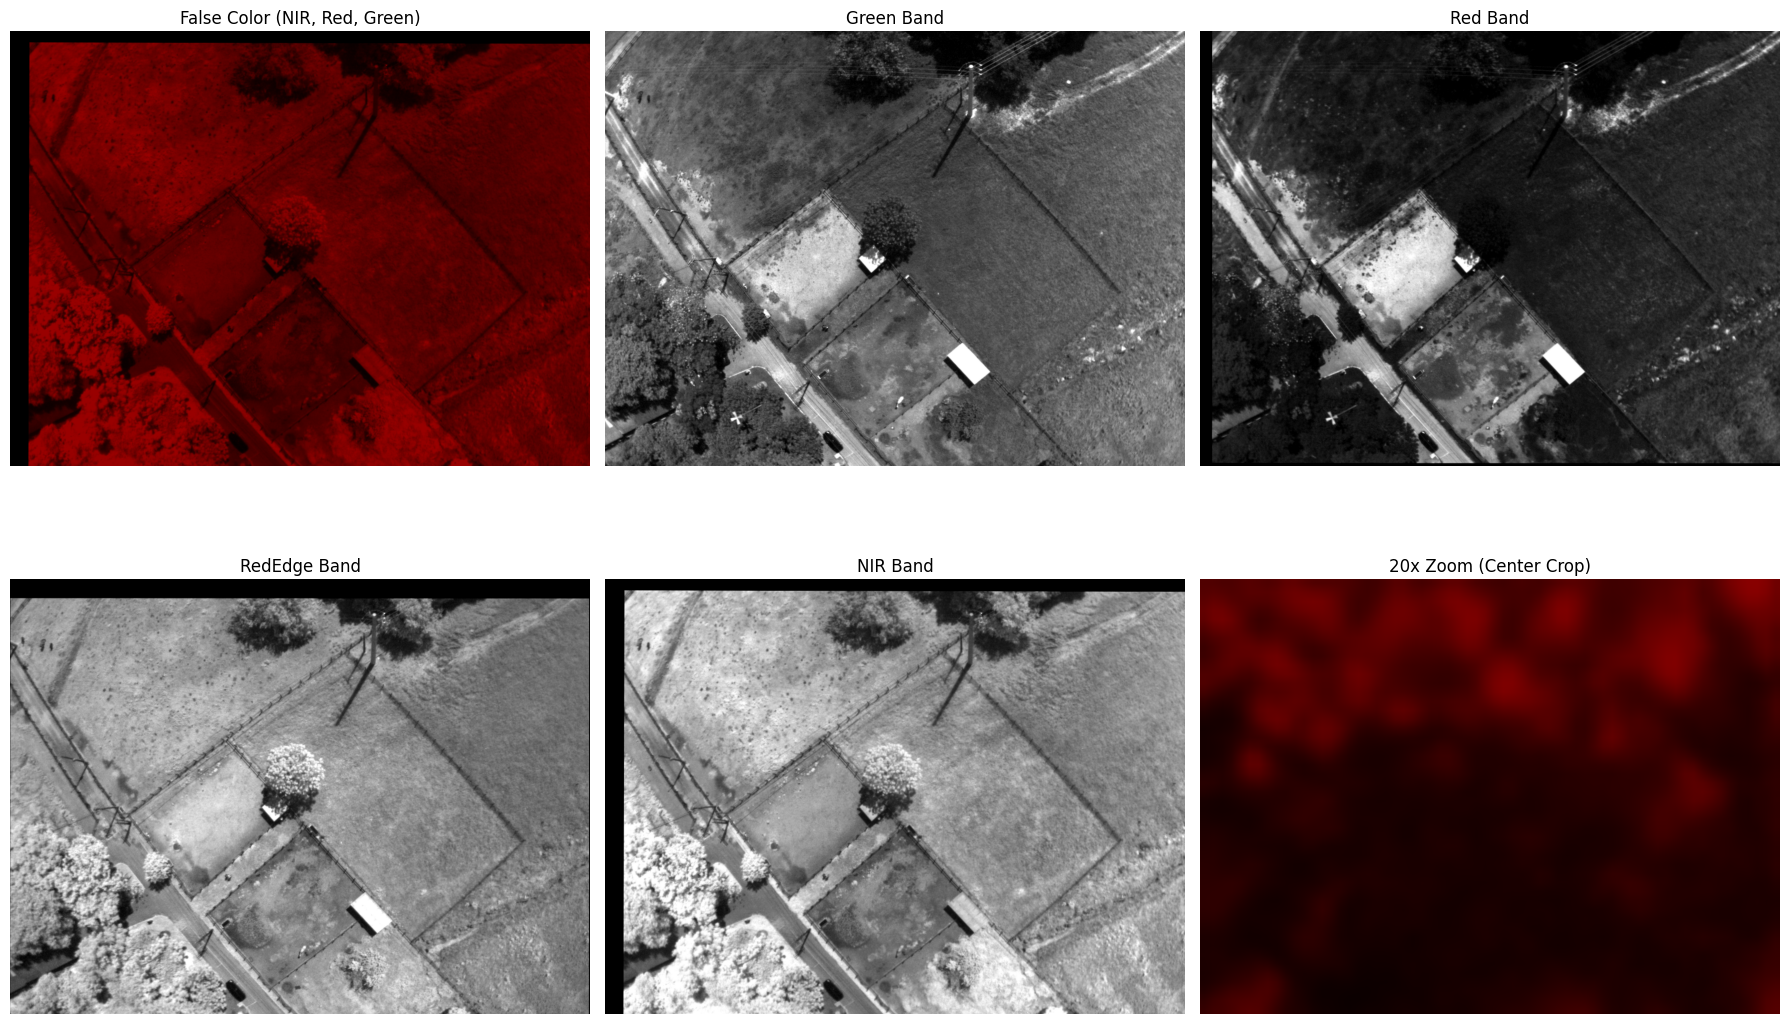

In [36]:
output_folder = "../data/processed/sequoia_localization"
display_image_bands(output_folder)


In [30]:
b["XMP"]

'<x:xmpmeta xmlns:x="adobe:ns:meta/">\n <rdf:RDF xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#">\n<rdf:Description rdf:about=""\n xmlns:Camera="http://pix4d.com/camera/1.0/"\n Camera:RigName="Sequoia"\n Camera:RigCameraIndex="0"\n Camera:Yaw="3.903888"\n Camera:Pitch="-14.096164"\n Camera:Roll="2.914485"\n Camera:BandGain="1.000000"\n Camera:SensorTemperature="74.500000"\n Camera:LineReadoutTime="23076"\n Camera:PrincipalPoint="2.390386,1.778139"\n Camera:ModelType="fisheye"\n Camera:FisheyeAffineSymmetric="1"\n Camera:FisheyeAffineMatrix="1656.149054703,0,0,1656.149054703"\n Camera:FisheyePolynomial="0,1,0.013969515,-0.154081278"\n Camera:FlightUUID="F9596A0B07A7228713AD3437E2692666"\n Camera:CaptureUUID="54B5BA3B89A94342D4602547EF1DC861"\n Camera:SunshineSerialNumber="PI040379BB7H005520"\n Camera:IrradianceCalibrationMeasurement="0,600,15,1,1,600,384,41,2,600,6550,744,3,600,65535,18196"\n Camera:CalibrationMeasurement="1,0.00675675675675676,472"\n Camera:CalibrationPicture="